In [122]:
import pandas as pd
import numpy as np

# data processing
from datetime import datetime, date, time
from dateutil.parser import parse

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# regression / matching
import statsmodels.formula.api as smf

## Load the data

In [123]:
data_path = "DATA/"

Mex_df = pd.read_csv(data_path+"Mex_daily_edac.txt", sep='\t')
Mex_offset_df = pd.read_csv(data_path+"MeX_EDAC_offset.txt", sep='\t')
Nac_df = pd.read_csv(data_path+"Nac_daily_edac.txt", sep='\t')
Ndm_df = pd.read_csv(data_path+"Ndm_daily_edac.txt", sep='\t')
Ros_nac_offset_df = pd.read_csv(data_path+"Ros_AOCS_NAC_offset.txt", sep='\t')
Ros_ndm_offset_df = pd.read_csv(data_path+"Ros_AOCS_NDM_offset.txt", sep='\t')
Vex_df = pd.read_csv(data_path+"VEX_NDMW0D0A_2023_01_11_12_55_55.900.txt", sep='\t')
Vex_boundary_df = pd.read_csv(data_path+"VEX-ICME-boundaries.csv")

## Venus Express data

In [124]:
display(Vex_df.head())
Vex_df.DATE_TIME.apply(lambda d: datetime.strptime(d, '%Y-%m-%d %H:%M:%S.%f'))
Vex_df.set_index('DATE_TIME', inplace=True)

,DATE_TIME,NDMW0D0A
0,2005-11-09 00:09:04.575,0
1,2005-11-09 00:10:08.575,0
2,2005-11-09 00:11:12.576,0
3,2005-11-09 00:12:16.576,0
4,2005-11-09 00:13:20.577,0


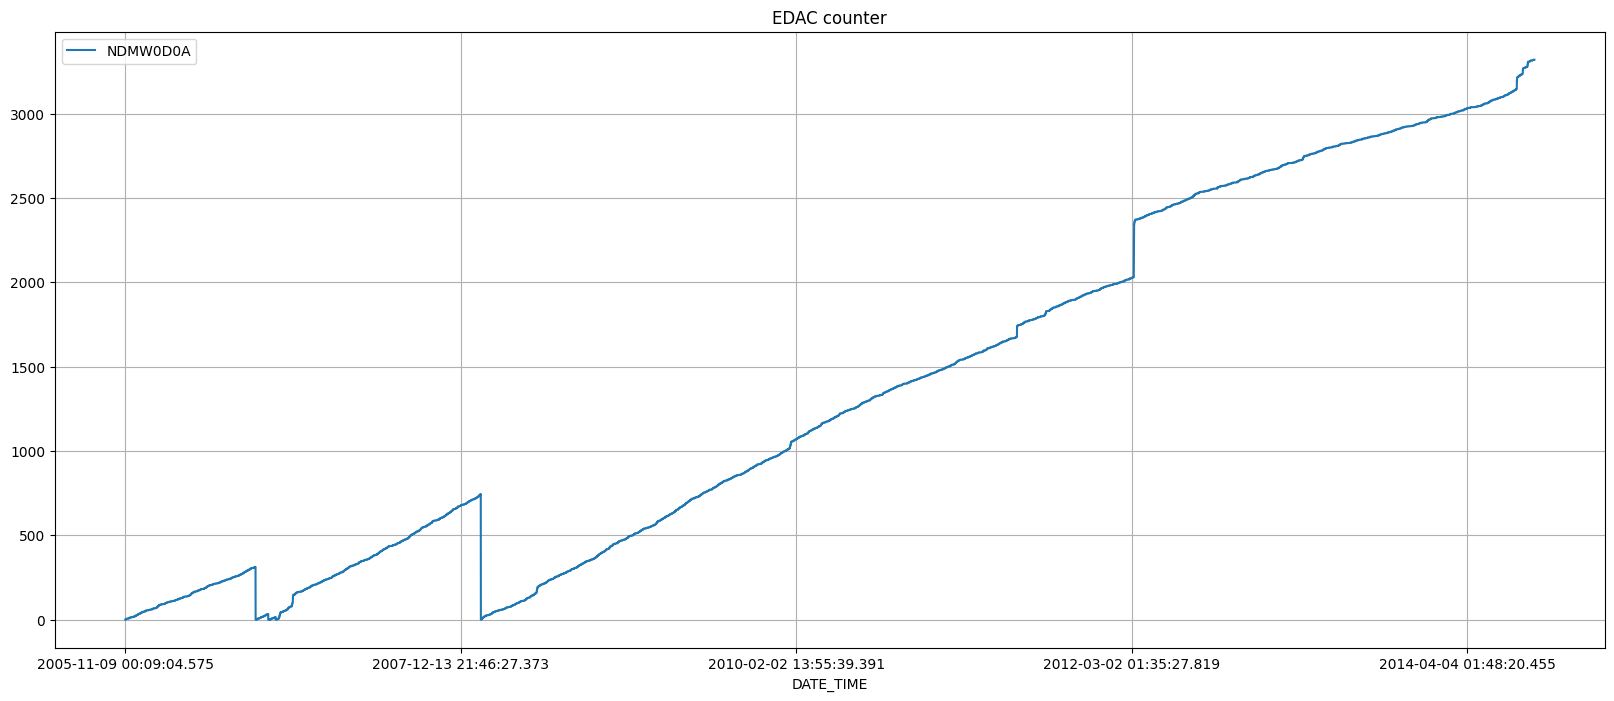

In [125]:
Vex_df.plot(kind='line', figsize=(20,8))
plt.title('EDAC counter')
plt.grid()
plt.show()

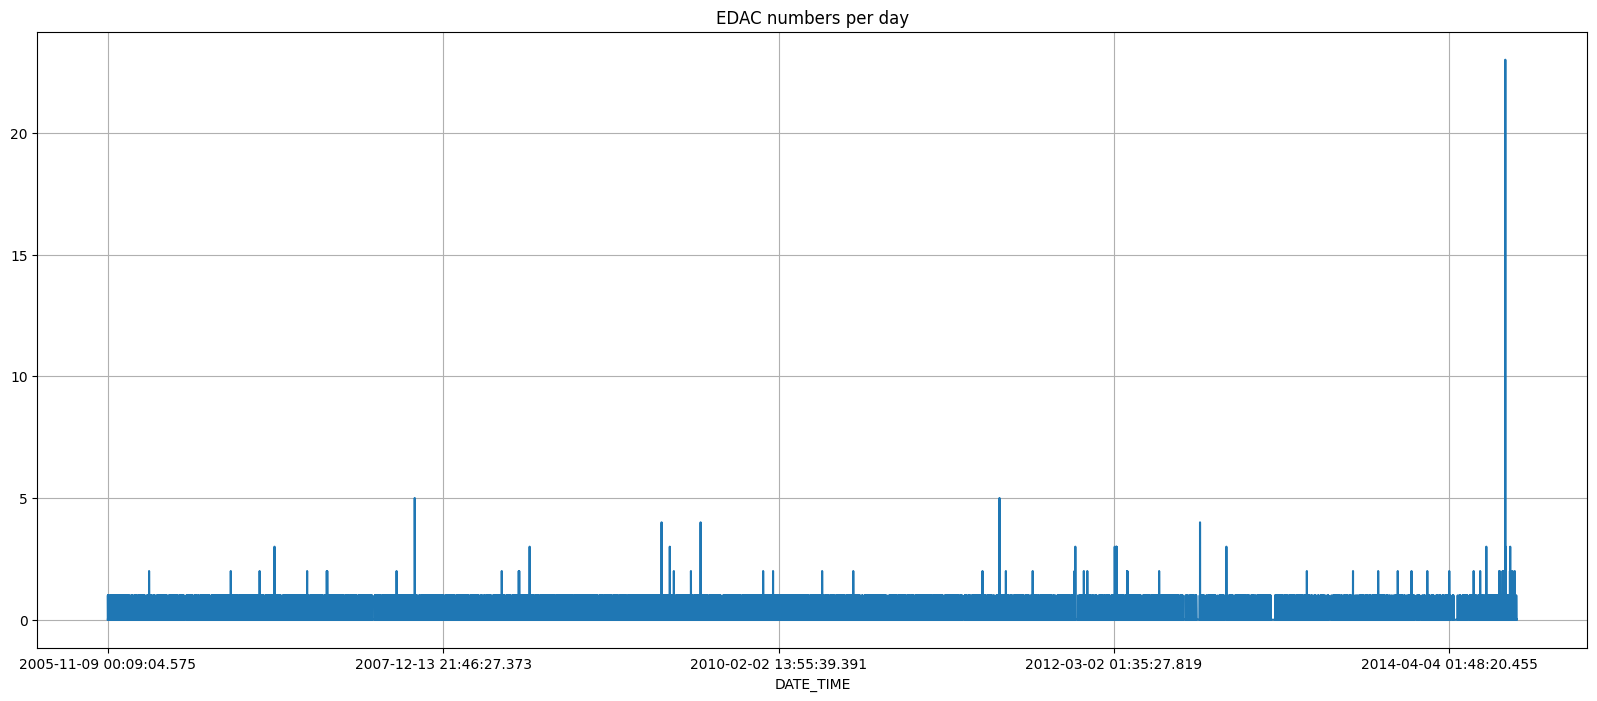

In [126]:
Vex_df.columns.tolist()
Vex_df['EDAC'] = Vex_df['NDMW0D0A'].diff().bfill().astype(int).map(lambda x: max(0, x))

Vex_df['EDAC'].plot(kind='line', figsize=(20,8))
plt.title('EDAC numbers per day')
plt.grid()
plt.show()

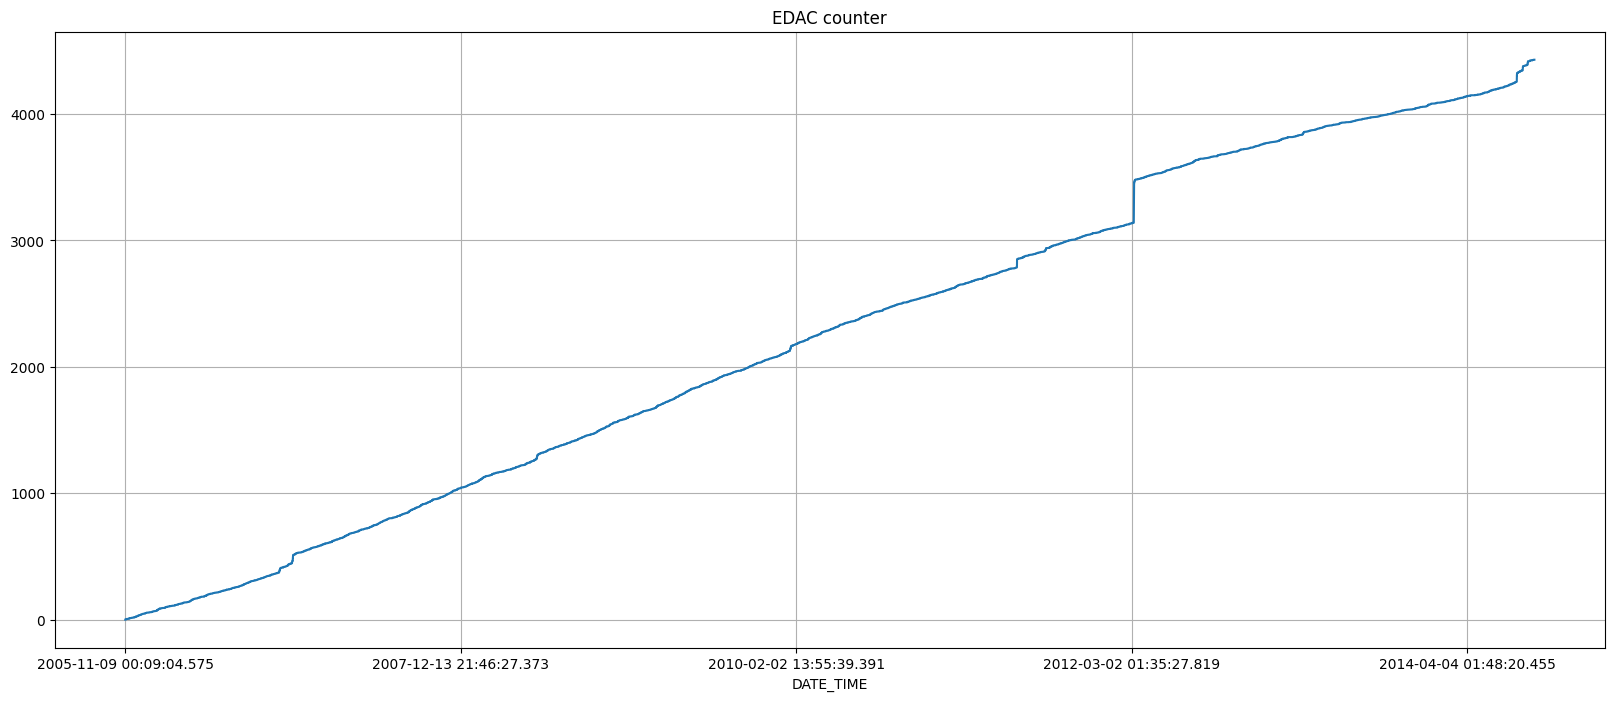

In [127]:
Vex_df['EDAC_counter'] = Vex_df['EDAC'].cumsum()

Vex_df['EDAC_counter'].plot(kind='line', figsize=(20,8))
plt.title('EDAC counter')
plt.grid()
plt.show()